## Build, Train & Score Model with PyTorch

### Introduction: Rahul Nair


In [1]:
%pip install seaborn
%pip install tqdm
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import Dependencies

In [2]:
import fnmatch
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="husl")


## Print Software Versions

In [3]:
print(f"torch version: {torch.__version__}")
print(f"ipex version: {ipex.__version__}")


torch version: 1.10.0a0+git2c516c0
ipex version: 1.10.100+cpu


## Define Utility Functions

### seed_everything and set_env_vars

In [4]:
def seed_everything(seed: int = 4242):
    """set all random seeds using `seed`"""
    print(f"seed set to: {seed}")
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def set_env_vars() -> int:
    """set openMP and torch params"""
    num_physical_cores = psutil.cpu_count(logical=False)
    print(f"setting omp num threads: {num_physical_cores}")
    os.environ["OMP_NUM_THREADS"] = str(num_physical_cores)
    os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
    os.environ["KMP_BLOCKTIME"] = "1"
    return num_physical_cores


seed_everything(9342)
num_physical_cores = set_env_vars()


seed set to: 9342
setting omp num threads: 12


## Define dataset transforms for training and validation sets

In [5]:
# training, validation  dataset transforms
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomApply(
                [transforms.GaussianBlur(kernel_size=(1, 3), sigma=(1, 3))], p=0.2
            ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(180),
            transforms.ToTensor(),
            transforms.Normalize(*imagenet_stats),
        ]
    ),
    "valid": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    ),
}


## Create dataset for Training and Validation

In [6]:
# create dataset for Training and Validation
num_physical_cores = psutil.cpu_count(logical=False)
data_dir = pathlib.Path("./data/ThreeClassManualRemove0s/")
TRAIN_DIR = data_dir / "train"
VALID_DIR = data_dir / "val"

# no image transforms for validation data
train_data = datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["train"])
valid_data = datasets.ImageFolder(VALID_DIR, transform=img_transforms["valid"])


## Define Utility Functions to visualize class distributions

### data_distribution and plot_data_distribution

In [7]:
def data_distribution(dataset=train_data, path: str = TRAIN_DIR) -> dict:
    """return dict of data distribtion of each class."""
    cls_count = dict.fromkeys(dataset.class_to_idx, 0)
    for cls in cls_count.keys():
        cls_count[cls] = len(fnmatch.filter(os.listdir(f"{path}/{cls}"), "*.png"))
    return cls_count


def plot_data_distribution(data_dist: dict, title: str = ""):
    """plot data distribution"""
    cls, count = list(data_dist.keys()), list(data_dist.values())
    p = sns.barplot(x=cls, y=count)
    p.set_title(title)


# Plot Data Distributions

train data dist: {'0': 1006, '1': 987, '2': 1356}


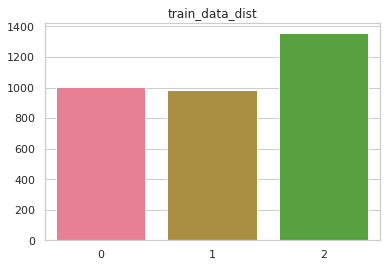

In [8]:
train_data_dist = data_distribution(train_data, path=TRAIN_DIR)
plot_data_distribution(train_data_dist, "train_data_dist")
print(f"train data dist: {train_data_dist}")


valid data dist: {'0': 239, '1': 231, '2': 341}


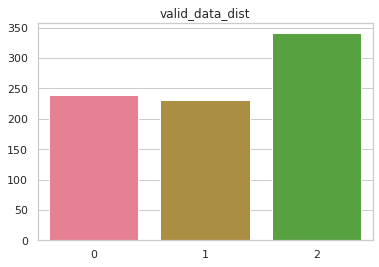

In [9]:
valid_data_dist = data_distribution(valid_data, path=VALID_DIR)
plot_data_distribution(valid_data_dist, "valid_data_dist")
print(f"valid data dist: {valid_data_dist}")


In [10]:
# create data loaders
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
print(f"batch size: {batch_size}")


batch size: 64


## Define Utility Functions to display data from dataloader



In [11]:
def _denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean to show images"""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean


def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=4, figsize=(10, 6)):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(dataloader))  # batch of with images, batch of labels
    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )  # get num_data of images, labels
    plt.style.use("dark_background")
    _, axes = plt.subplots(1, num_data, figsize=figsize)
    for n in range(num_data):
        axes[n].set_title(labels[n])
        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))


## Display Sample Data

training data


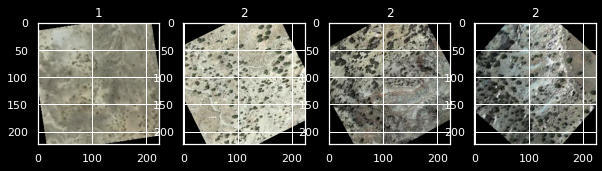

In [12]:
print("training data")
show_data(train_dataloader)


validation data


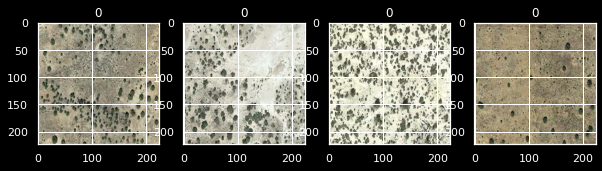

In [13]:
print("validation data")
show_data(valid_dataloader)


## Define the Model Class
    Our model is a Resnet18 based 3 class classification Deep Neural Network

### AKA DinosaurBoneFinder Class

In [14]:
class DinosourBoneFinder(nn.Module):
    """
    A model to classify aerial images that could potentially have Jurassic fossils.
    We are using a pretrained resnet backbone model
    and images given to model are classified into one of 3 classes.
    0 - no bone
    1 - bone possible
    2 - bone likely


    We currently use the resnet18 model as a backbone
    """

    def __init__(self, backbone=18, simple=False):
        super(DinosourBoneFinder, self).__init__()
        backbones = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
        }
        self.network = backbones[backbone](pretrained=True)
        for m, p in zip(self.network.modules(), self.network.parameters()):
            if isinstance(m, nn.BatchNorm2d):
                p.requires_grad = False
        if simple:
            self.network.fc = nn.Linear(self.network.fc.in_features, 3)
        else:
            self.network.fc = nn.Sequential(
                nn.Linear(self.network.fc.in_features, 256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(
                    256, 3
                ),  # here we are using 3 for `out_features` as the image given
                # to the model can be one of 3 classes (0 - no bone, 1 - bone possible, 2 - bone likely)
            )

    def forward(self, x_batch):
        return self.network(x_batch)


## Define Metrics - Utility class to measure accuracy of the model and plot metrics

In [15]:
class Metrics:
    """class that holds logic for calculating accuracy and printing it"""

    def __init__(self):
        self.acc = {"train": [], "val": []}
        self.loss = {"train": [], "val": []}

    @staticmethod
    @torch.no_grad()
    def accuracy(yhat, labels, debug):
        """accuracy of a batch"""
        yhat = torch.log_softmax(yhat, dim=1)  # softmax of logit output
        yhat = yhat.max(1)[1]  # get index of max values
        if debug:
            print(f"outputs: {yhat}")
            print(f"labels: {labels}")
        acc = yhat.eq(labels).sum() / len(yhat)
        return acc

    def __str__(self):
        return (
            f"loss:\n training set  : {self.loss['train'][-1]:.4}\n validation set: {self.loss['val'][-1]:.4}\n"
            f"accuracy:\n training set  : {self.acc['train'][-1]:.4}\n validation set: {self.acc['val'][-1]:.4} "
        )

    def plot(self):
        """plot loss and acc curves"""
        train_acc = [x * 100 for x in self.acc["train"]]
        val_acc = [x * 100 for x in self.acc["val"]]
        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 2.5))
        ax[0].plot(self.loss["train"], "-o")
        ax[0].plot(self.loss["val"], "-o")
        ax[0].set_ylabel("loss")
        ax[0].set_title(f"Train vs validation loss")
        ax[1].plot(train_acc, "-o")
        ax[1].plot(val_acc, "-o")
        ax[1].set_ylabel("accuracy (%)")
        ax[1].set_title("Training vs validation acc")
        for x in ax:
            x.yaxis.grid(True)
            x.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            x.legend(["train", "validation"])
            x.set_xlabel("epoch")
        plt.show()


# Define Trainer Class

In [16]:
class Trainer:
    """Trainer class that takes care of training and validation passes."""

    def __init__(
        self,
        model,
        device="cpu",
        optimizer=torch.optim.SGD,
        epochs=10,
        lr=0.05,
        ipx=False,
    ):
        self.device = device
        self.model = model.to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.ipx = ipx
        self.epochs = epochs
        self.metrics = Metrics()
        self.lr = lr
        if isinstance(optimizer, torch.optim.Adam):
            self.lr = 2e-3
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

    def forward_pass(self, inputs, labels, debug=False):
        """Perform forward pass of models with `inputs`,
        calculate loss and accuracy and return it.
        """
        outputs = self.model(inputs)  # forward pass model
        loss = self.loss_fn(outputs, labels)  # calculate loss
        acc = self.metrics.accuracy(outputs, labels, debug=debug)
        return loss, acc

    def train_one_batch(self, max_epoch=100):
        """Train the model using just one batch for max_epoch.
        use this function to debug the training loop"""
        self.model.train()
        inputs, labels = next(iter(self.train_dataloader))
        for epoch in range(max_epoch):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()  # zero gradients
            loss, _ = self.forward_pass(inputs, labels, debug=True)
            loss.backward()  # calculate gradients
            self.optimizer.step()  # update params
            print(
                f"[Epoch: {epoch+1}]\
                    \n loss: {loss.item()/len(self.train_dataloader):.4f}"
            )

    def train(self):
        """Training loop, return epoch loss and accuracy."""
        self.model.train()
        t_epoch_loss, t_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(train_dataloader, desc="tr loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            if self.ipx:
                inputs = inputs.to(memory_format=torch.channels_last)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels)  # forward pass
            loss.backward()  # backward
            self.optimizer.step()  # update gradients
            t_epoch_loss += loss.item()
            t_epoch_acc += acc.item()
        return (t_epoch_loss, t_epoch_acc)

    @torch.no_grad()
    def validate(self):
        """Validation loop, return validation epoch loss and accuracy."""
        self.model.eval()
        v_epoch_loss, v_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(self.valid_dataloader, desc="ev loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            loss, acc = self.forward_pass(inputs, labels)
            v_epoch_loss += loss.item()
            v_epoch_acc += acc.item()
        return (v_epoch_loss, v_epoch_acc)

    def _to_ipx(self):
        """convert model memory format to channels_last to IPEX format."""
        self.model.train()
        self.model = self.model.to(memory_format=torch.channels_last)
        self.model, self.optimizer = ipex.optimize(
            self.model, optimizer=self.optimizer, dtype=torch.float32
        )

    def fine_tune(self, train_dataloader, valid_dataloader, debug=False):
        """Fine tune `self.model` using training set and measure perf using
        training and validation set.

        `debug`: if True, will run train_one_batch function with one batch
        of train_dataloader to see if we can overfit the model, used to debug
        the training loop.

        `train_dataloader`: training set
        `valid_dataloader`: validation set
        """
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        if debug:
            self.train_one_batch()
        else:
            time_per_epoch = []
            if self.ipx:
                self._to_ipx()
            print(f"fine tuning model for max epochs: {self.epochs}")
            for epoch in range(self.epochs):
                print(f"Epoch: [{epoch+1}]")
                st_time = time.perf_counter()
                t_epoch_loss, t_epoch_acc = self.train()
                fn_time = time.perf_counter()
                time_per_epoch.append(fn_time - st_time)
                v_epoch_loss, v_epoch_acc = self.validate()
                self.metrics.loss["train"].append(t_epoch_loss / len(train_dataloader))
                self.metrics.loss["val"].append(v_epoch_loss / len(valid_dataloader))
                self.metrics.acc["train"].append(t_epoch_acc / len(train_dataloader))
                self.metrics.acc["val"].append(v_epoch_acc / len(valid_dataloader))
                print(self.metrics)
            return time_per_epoch


## Train model

In [17]:
model = DinosourBoneFinder()  # init model
trainer = Trainer(model, epochs=6, ipx=True)  # set up trainer with the model
tft = trainer.fine_tune(train_dataloader, valid_dataloader)


fine tuning model for max epochs: 6
Epoch: [1]


ev loop: 100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


loss:
 training set  : 0.3586
 validation set: 0.1212
accuracy:
 training set  : 0.8514
 validation set: 0.9555 
Epoch: [2]


ev loop: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


loss:
 training set  : 0.1512
 validation set: 0.4225
accuracy:
 training set  : 0.9442
 validation set: 0.8175 
Epoch: [3]


ev loop: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


loss:
 training set  : 0.1366
 validation set: 1.707
accuracy:
 training set  : 0.9504
 validation set: 0.6333 
Epoch: [4]


ev loop: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


loss:
 training set  : 0.1034
 validation set: 0.1103
accuracy:
 training set  : 0.9611
 validation set: 0.9519 
Epoch: [5]


ev loop: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


loss:
 training set  : 0.0819
 validation set: 0.07625
accuracy:
 training set  : 0.9714
 validation set: 0.9682 
Epoch: [6]


ev loop: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

loss:
 training set  : 0.07076
 validation set: 0.04098
accuracy:
 training set  : 0.9741
 validation set: 0.982 


## Training / Validation loss and accuracy metrics

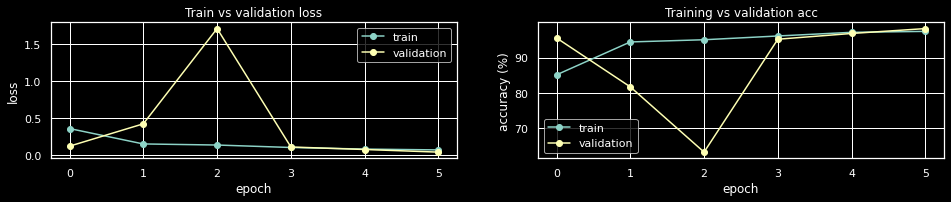

In [18]:
trainer.metrics.plot()


## Save the model 

Save it for later use

In [19]:
model_name = "resnet18_3Class_RN"
model_scripted = torch.jit.script(model)  # Export to TorchScript
model_scripted.save(f"models/{model_name}.pt")  # Save


## Load a Saved Model

Use this to load a previously created model to test if we were successfully able to save the model.

In [20]:
model_name = "resnet18_3Class_RN"
model_read = torch.jit.load(f"models/{model_name}.pt")
model_read.eval()


RecursiveScriptModule(
  original_name=DinosourBoneFinder
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
     

## Infer Function

Used to score and get associated filename for each scored image

In [21]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)
        return super().__getitem__(index) + paths


def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose
    labels have to be predicted are kept.

    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.

    returns: (
        images: images loaded from disk for inferece,
        yhats: predicted labels
        paths: image file-path on disk        )
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = ImageFolderWithPaths(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=4,
    )
    yhats = []
    images = []
    paths = []
    for (imgs, _, fpaths) in dataloader:
        yhat = model(imgs)
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        paths.extend(fpaths)
        images.extend(imgs.data.cpu())
    return images, yhats, paths


## How to use the Infer()

In [22]:
!mkdir data/ThreeClassManualRemove0s/test
!mkdir  data/ThreeClassManualRemove0s/test/unknown
!cp data/DinosaurNationalMonument/20220514/224/*.jpg data/ThreeClassManualRemove0s/test/unknown/

mkdir: cannot create directory ‘data/ThreeClassManualRemove0s/test’: File exists
mkdir: cannot create directory ‘data/ThreeClassManualRemove0s/test/unknown’: File exists


infered images with labels


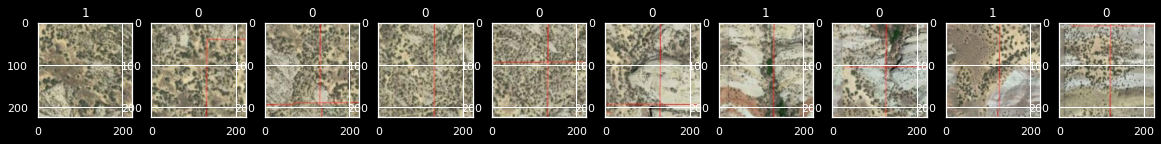

In [23]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
images, yhats, img_paths = infer(
    model_read, data_path="./data/ThreeClassManualRemove0s/test/"
)
infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=100, shuffle=False)
print("infered images with labels")
show_data(infer_dataloader, imagenet_stats, 10, figsize=(20, 8))


If you have any issues or want to contribute, please contact our authors:
Intel oneAPI Solution Architect
- Unnikrishnan Nair, Rahul [rahul.unnikrishnan.nair (at) intel.com]
- Chesebrough, Bob [bob.chesebrough (at) intel.com]

## Lab

1. What will happen to the accuracy curves & training time:
    - if we use ResNet50 as the backbone instead of ResNet18?
    - if another optimizer is used, for Eg. Instead of SGD, if we used Adam?
2. Difference in time taken for training with ipex and without ipex?</br>
    **Note**: To do this experiment, call the `fine_tune` method using `ipx=False`
3. If we don't use the fine-tuning approach and use the same Resnet18 with pretraining turned off (`pretrain=False`), how many epochs do we have to train the model?
4. If we don't `zero` the gradients in the training loop, what effect does it have on training?
5. Can a custom CNN-based classifier be trained to classify our dataset more accurately than the approach we used here?

